In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
df1 = pd.read_csv("reliance dataset_1.csv")
df2 = pd.read_csv("reliance dataset_2.csv")
df3 = pd.read_csv("reliance dataset_3.csv")
df_underlying = pd.read_csv("reliance_underlying_2023.csv")

In [3]:
def data_transf(df):
 df_transformed = df[(df['OPEN PRICE '] != '-') & (df['HIGH PRICE '] != '-') & (df['LOW PRICE '] != '-')]
 
 df_transformed['EXPIRY DATE '] = pd.to_datetime(df_transformed['EXPIRY DATE '])
 df_transformed['DATE '] = pd.to_datetime(df_transformed['DATE '])
 df_transformed['TIME TO EXPIRY (YEARS) '] = ((df_transformed['EXPIRY DATE '] - df_transformed['DATE '])/np.timedelta64(1, 'D'))/365
 
 df_transformed[["STRIKE PRICE ","OPEN PRICE ","HIGH PRICE ","LOW PRICE ","CLOSE PRICE ","LAST PRICE ","SETTLE PRICE ","Volume ","VALUE ","PREMIUM VALUE ","OPEN INTEREST ","CHANGE IN OI "]] = df_transformed[["STRIKE PRICE ","OPEN PRICE ","HIGH PRICE ","LOW PRICE ","CLOSE PRICE ","LAST PRICE ","SETTLE PRICE ","Volume ","VALUE ","PREMIUM VALUE ","OPEN INTEREST ","CHANGE IN OI "]].applymap(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x)
 return df_transformed

def data_transf_underlying(df_underlying_asset):
 df_underlying_transformed = df_underlying_asset[['Date ', 'close ']]
 df_underlying_transformed['Date '] = pd.to_datetime(df_underlying_transformed['Date '])
 df_underlying_transformed = df_underlying_transformed.applymap(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x)
 return df_underlying_transformed

def data_merge(df, df_underlying_asset):
 df_underlying_transformed = data_transf_underlying(df_underlying_asset)
 df_merged = pd.merge(df, df_underlying_transformed, left_on = 'DATE ', right_on = 'Date ')
 return df_merged

In [4]:
df1 = data_transf(df1)
df1 = data_merge(df1, df_underlying)

df2 = data_transf(df2)
df2 = data_merge(df2, df_underlying)

df3 = data_transf(df3)
df3 = data_merge(df3, df_underlying)


C:\Users\Admin\AppData\Local\Temp\ipykernel_9228\954608262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed['EXPIRY DATE '] = pd.to_datetime(df_transformed['EXPIRY DATE '])
C:\Users\Admin\AppData\Local\Temp\ipykernel_9228\954608262.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed['DATE '] = pd.to_datetime(df_transformed['DATE '])
C:\Users\Admin\AppData\Local\Temp\ipykernel_9228\954608262.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [5]:
def black_scholes_function(K, S, t, r, sigma):
    # r and sigma as fraction annual rates (eg 0.2 for 20% annual rate) 
    # K, S in currency units
    # t in years
    d1 = (np.log(S/K) + (r + (sigma**2)/2)*t)/(sigma*(np.sqrt(t)))
    d2 = d1 - (sigma*(np.sqrt(t)))
    
    N1 = stats.norm.cdf(d1, loc=0, scale=1)
    N2 = stats.norm.cdf(d2, loc=0, scale=1)

    C = N1*S - N2*K*(np.exp(-r*t))

    return C

def black_scholes_pred(df, r, sigma):
    # input r and sigma as fraction annual rates (eg 0.2 for 20% annual rate) 
    prices = black_scholes_function(df['STRIKE PRICE '], df['close '], df['TIME TO EXPIRY (YEARS) '], r, sigma)
    final_data = df = pd.DataFrame({
     'Date ': df['DATE '],
     'predicted_price': prices
     })
    return final_data
    
def volatility_calculator(df_underlying_asset):
    #Gives annual volatility as a fraction of 100
    df_underlying_transformed = data_transf_underlying(df_underlying_asset)
    log_returns = np.zeros((df_underlying_transformed.shape[0] - 1, 1))

    for i in range(log_returns.shape[0]):
     log_returns[i] = np.log((df_underlying_transformed['close '][i+1])/(df_underlying_transformed['close '][i]))

    daily_volatility = np.std(log_returns)

    sigma = daily_volatility * np.sqrt(log_returns.shape[0])
    return sigma

In [9]:
df1_result = black_scholes_pred(df1, 0.07, volatility_calculator(df_underlying))
df1_result['actual_price'] = df1['CLOSE PRICE ']

df2_result = black_scholes_pred(df2, 0.07, volatility_calculator(df_underlying))
df2_result['actual_price'] = df2['CLOSE PRICE ']

df3_result = black_scholes_pred(df3, 0.07, volatility_calculator(df_underlying))
df3_result['actual_price'] = df3['CLOSE PRICE ']

C:\Users\Admin\AppData\Local\Temp\ipykernel_9228\954608262.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_underlying_transformed['Date '] = pd.to_datetime(df_underlying_transformed['Date '])
C:\Users\Admin\AppData\Local\Temp\ipykernel_9228\954608262.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_underlying_transformed = df_underlying_transformed.applymap(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x)
C:\Users\Admin\AppData\Local\Temp\ipykernel_9228\954608262.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Text(0.5, 1.0, 'Red: predicted\nGreen: Actual\nDataset 3 (K = 2600)')

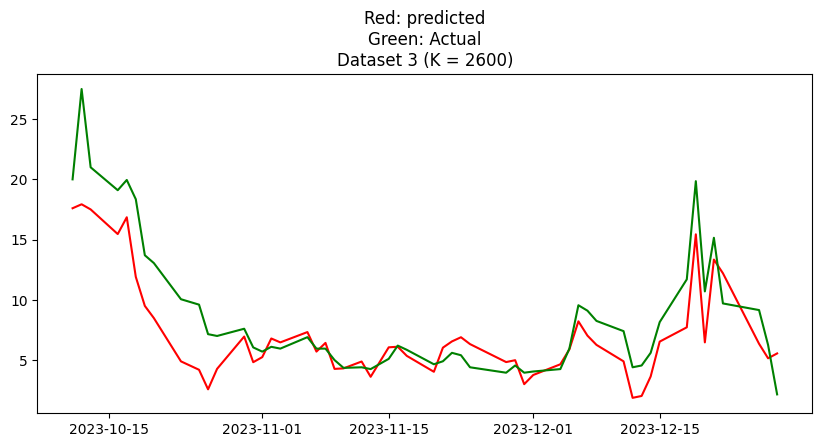

In [29]:
plt.figure(figsize = (10, 15))

# plt.subplot(3,1,1)
# plt.plot(df1_result['Date '], df1_result['predicted_price'], color = 'red')
# plt.plot(df1_result['Date '], df1_result['actual_price'], color = 'green')
# plt.title('Red: predicted\nGreen: Actual\nDataset 1 (K = 2400)')

# plt.subplot(3,1,2)
# plt.plot(df2_result['Date '], df2_result['predicted_price'], color = 'red')
# plt.plot(df2_result['Date '], df2_result['actual_price'], color = 'green')
# plt.title('Red: predicted\nGreen: Actual\nDataset 2 (K = 2500)')

plt.subplot(3,1,3)
plt.plot(df3_result['Date '], df3_result['predicted_price'], color = 'red')
plt.plot(df3_result['Date '], df3_result['actual_price'], color = 'green')
plt.title('Red: predicted\nGreen: Actual\nDataset 3 (K = 2600)')